In [71]:
############################################
##      Requires: NumPy, SciPy, tqdm      ##
############################################
from mcmcdagtargets import MCMCDagTargets

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle

In [99]:
# Open the pickle file in binary read mode and load the object
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

# Now you can use the loaded_data object
print("Loaded data:", data)

Loaded data: {'X': matrix([[ 1.50625406,  1.15251472,  0.88886904, ..., -0.02336408,
          0.00559344,  1.86053198],
        [ 1.64109446,  1.47208506,  0.20007073, ...,  0.12160048,
         -0.39372965,  0.45830295],
        [-1.06417076, -0.49646694, -1.68379025, ...,  1.95469665,
         -0.81020864,  0.58458485],
        ...,
        [ 0.60605526, -1.93693803, -3.30506494, ...,  0.10201005,
         -1.09474199, -0.13719904],
        [-0.01860035, -2.31241116, -2.40077035, ...,  0.22518605,
          0.70435278,  0.61758734],
        [ 1.30126128, -0.83466799, -1.13816928, ..., -1.13358517,
          1.01344457,  0.03093699]]), 'D': matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}


In [102]:
X = pd.DataFrame(data['X'])
Targets_true = data['D']

X['Fault'] = np.concatenate((np.repeat(0, 2000), np.repeat(1, 2000)))

In [104]:
X0 = X[X['Fault'] == 0].drop(['Fault'], axis=1)
X1 = X[X['Fault'] == 1].drop(['Fault'], axis=1)


def corr_selection(data, thresh):
    # Calculate the correlation matrix
    correlation_matrix = X.corr()

    # Select features based on a threshold (e.g., 0.7)
    threshold = thresh
    highly_correlated = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                mean_corr_i = abs(correlation_matrix[colname_i]).mean()
                mean_corr_j = abs(correlation_matrix[colname_j]).mean()

                if mean_corr_i > mean_corr_j:
                    highly_correlated.add(colname_j)
                else:
                    highly_correlated.add(colname_i)

    return list(highly_correlated)


highcorr_X0 = corr_selection(X0, 0.7)
#highcorr_X1 = corr_selection(X1, 0.7)

data_0 = X0.drop(highcorr_X0, axis=1)
data_1 = X1.drop(highcorr_X0, axis=1)

#keep = list(np.unique(list(data_0.columns) + list(data_1.columns)))

data_keep = X[list(data_0.columns)]

data_keep

,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19
0,1.506254,1.152515,0.888869,-0.599898,-1.181500,-0.692466,-1.770789,-0.231296,-1.143666,0.370755,1.462288,-0.320398,1.003781,-0.064002,0.905652,-0.553959,-0.023364,0.005593,1.860532
1,1.641094,1.472085,0.200071,-0.269699,0.966886,0.424066,-0.046954,0.359126,-0.257520,0.091447,-0.861090,1.855101,-0.708269,-1.156279,-0.548166,-0.737641,0.121600,-0.393730,0.458303
2,-1.064171,-0.496467,-1.683790,-0.325517,-1.142183,0.387913,1.768704,-1.199359,1.687639,0.292613,-2.254053,1.079951,-0.150687,-0.574007,-0.531857,-1.204315,1.954697,-0.810209,0.584585
3,-0.973218,-0.333011,1.251594,-1.180394,0.466158,-0.189787,-0.652119,-0.701472,1.735853,-1.560835,-1.076786,-0.824852,-2.215528,-0.739934,-0.096455,0.663875,1.860972,-1.197879,0.062642
4,0.685131,-0.831905,-0.621772,1.499423,0.539468,-0.894267,0.484327,-0.616651,-2.997612,1.096752,1.716529,1.651693,-1.201854,-0.439139,-0.476906,0.839457,-2.019715,0.979345,0.312524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.581574,0.988136,-4.153483,-0.254655,-0.064072,1.222353,-3.359042,0.032735,-0.816780,-0.315103,0.240236,2.801314,-0.200453,-0.841716,0.598412,0.029945,-0.612424,0.191998,-0.009788
3996,0.195435,-1.159203,2.730783,-0.262290,1.736802,0.400058,-1.249929,0.127208,-1.362352,-1.389666,0.302380,-1.043021,2.223715,-0.537235,1.455108,0.078958,0.808253,0.671513,0.015825
3997,0.606055,-1.936938,-3.305065,0.041217,2.485167,0.660859,-0.935813,0.003150,-0.628639,0.618119,-0.291242,2.576037,-0.100403,0.018493,0.940718,-0.535720,0.102010,-1.094742,-0.137199
3998,-0.018600,-2.312411,-2.400770,0.488049,1.089214,0.685642,0.573354,0.323336,1.149828,-0.581365,0.215208,2.281300,-0.569741,1.584487,-0.009764,1.814254,0.225186,0.704353,0.617587


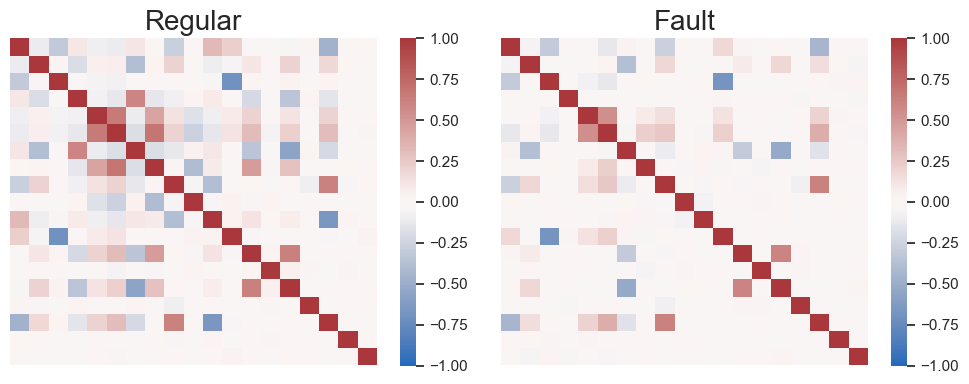

In [105]:
# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

pal = sns.color_palette("vlag", as_cmap=True)

# Plotting first heatmap on the first subplot
sns.heatmap(data_0.corr(), ax=axes[0], annot=False, cmap=pal, vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
axes[0].set_title('Regular', fontsize=20)

# Plotting second heatmap on the second subplot
sns.heatmap(data_1.corr(), ax=axes[1], annot=False, cmap=pal, vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
axes[1].set_title('Fault', fontsize=20)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Correlation structure mutation between Regular and Fault period

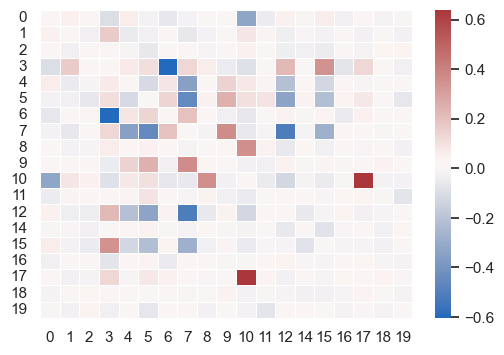

In [106]:
delta_corr = data_1.corr() - data_0.corr()

plt.figure(figsize=(6, 4))
palette = sns.color_palette("vlag", as_cmap=True)

sns.set_theme(style="white")
#palette = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(delta_corr, linewidths=.5, cmap=palette)

plt.show()

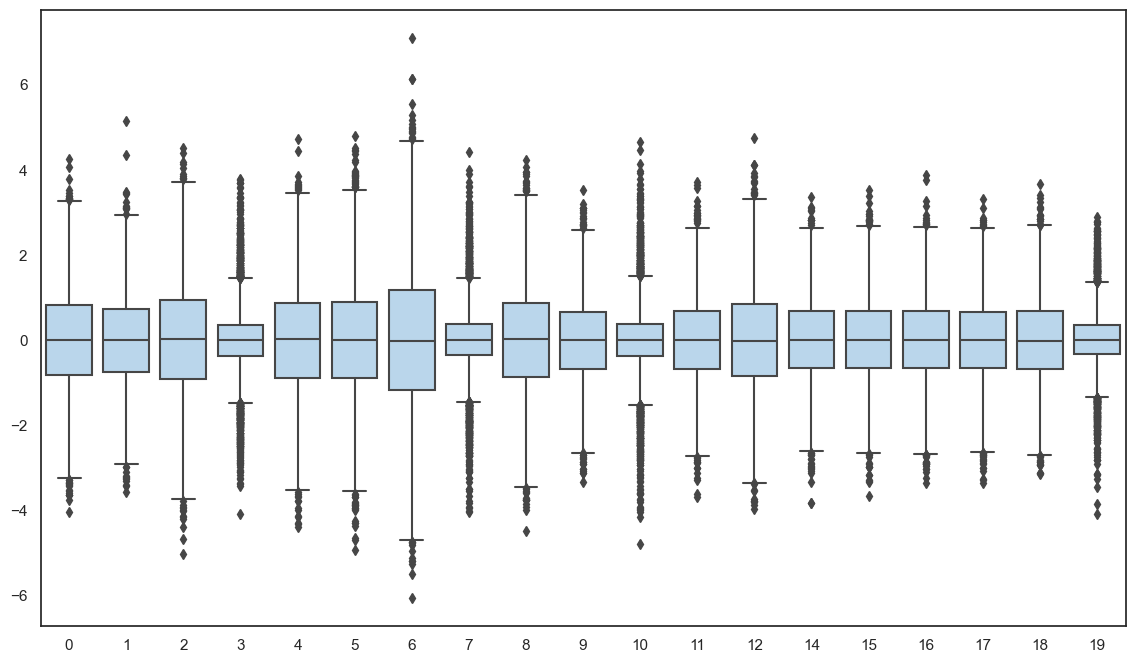

In [108]:
plt.figure(figsize=(14, 8))
col = sns.color_palette('Blues')[1]
sns.boxplot(data_keep, boxprops=dict(facecolor=col))
#plt.title('Scaled features distribution', fontsize=16, y=1.05)
plt.show()

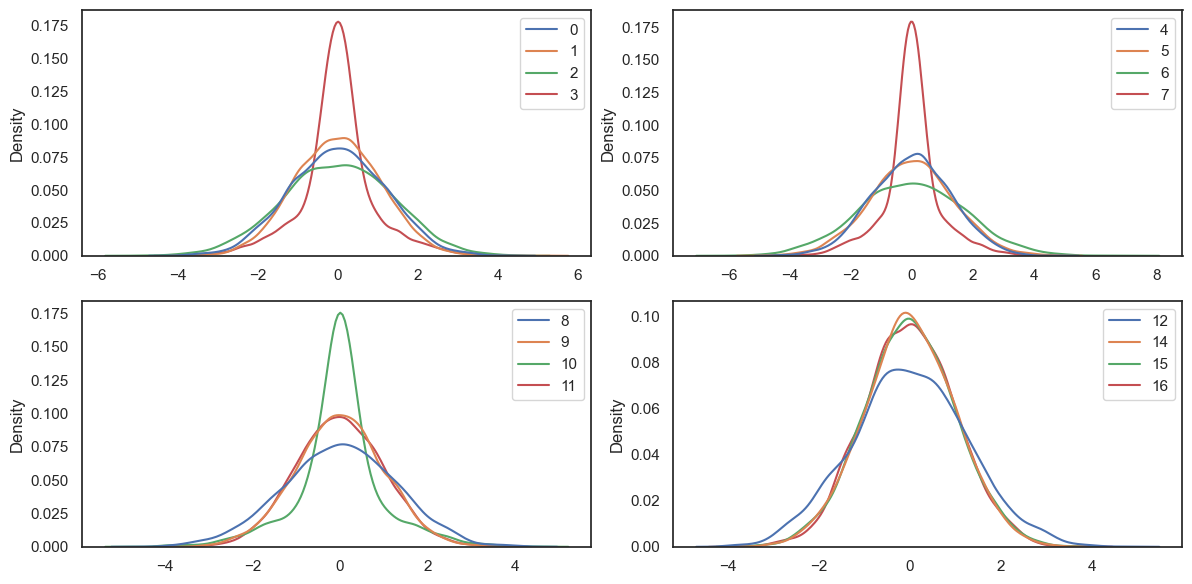

In [109]:
# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plotting first heatmap on the first subplot
sns.kdeplot(data_keep.iloc[:, :4], ax=axes[0,0])
sns.kdeplot(data_keep.iloc[:, 4:8], ax=axes[0,1])
sns.kdeplot(data_keep.iloc[:, 8:12], ax=axes[1,0])
sns.kdeplot(data_keep.iloc[:, 12:16], ax=axes[1,1])

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.suptitle('KDE Plots for feature subsets', fontsize=16, y = 1.05)
plt.savefig('kdeplots.png', bbox_inches='tight')
plt.show()

In [113]:
data_keep.loc[:,'Fault'] = np.concatenate((np.repeat(0, 2000), np.repeat(1, 2000)))

In [115]:
mcmc = MCMCDagTargets(seed = None)

K     = 2
n_all = [data_keep[data_keep["Fault"] == 0].shape[0], data_keep[data_keep["Fault"] == 1].shape[0]]
X = data_keep.drop(columns=["Fault"])
X = np.matrix(X)
q = X.shape[1]

## Fix hyperparameters of Beta(a_k,b_k) prior on the probabilities of intervention and prior probability of edge inclusion w
a_k = 1/q
b_k = 1
w   = 0.1

## Fix number of MCMC iterations and burn-in
S    = 10000
burn = 2000

# Run MCMC algorithm
out = mcmc.mcmc_dag_targets(
    X = X, 
    S = S, 
    burn = burn,
    w = w, a = None, a_k = a_k, b_k = b_k, n_all = n_all)

Targets_estimate = out['Targets_estimate']
P_DAG_estimate = out['P_DAG_estimate']
DAG_estimate = out['DAG_estimate']
Trace_DAG_edges = out['Trace_DAG_edges']

MCMC Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

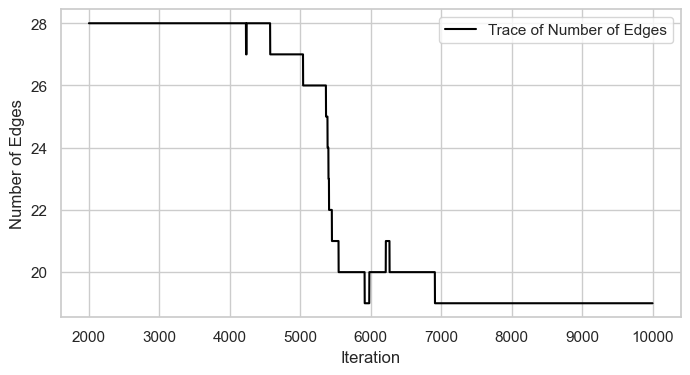

In [116]:
plt.figure(figsize=(8, 4))

# Set Seaborn style and color palette
sns.set(style="whitegrid")

# Plot the trace using Seaborn
sns.lineplot(x=range(burn, S), y=Trace_DAG_edges[burn:S], label='Trace of Number of Edges', color="Black")
#plt.title('Trace Plot for Convergence Diagnostics - Number of Edges', y=1.05)
plt.xlabel('Iteration')
plt.ylabel('Number of Edges')
plt.legend()
plt.show()

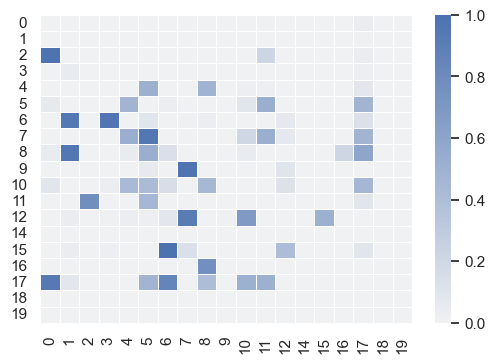

In [118]:
plt.figure(figsize=(6, 4))
palette = sns.color_palette("light:b", as_cmap=True)

sns.set_theme(style="white")
#palette = sns.color_palette("rocket_r", as_cmap=True)
DAG_hm = sns.heatmap(P_DAG_estimate, linewidths=.5, cmap=palette)

DAG_hm.set_xticklabels(data_keep.columns.drop('Fault'), rotation=90)
DAG_hm.set_yticklabels(data_keep.columns.drop('Fault'), rotation=0)

plt.show()

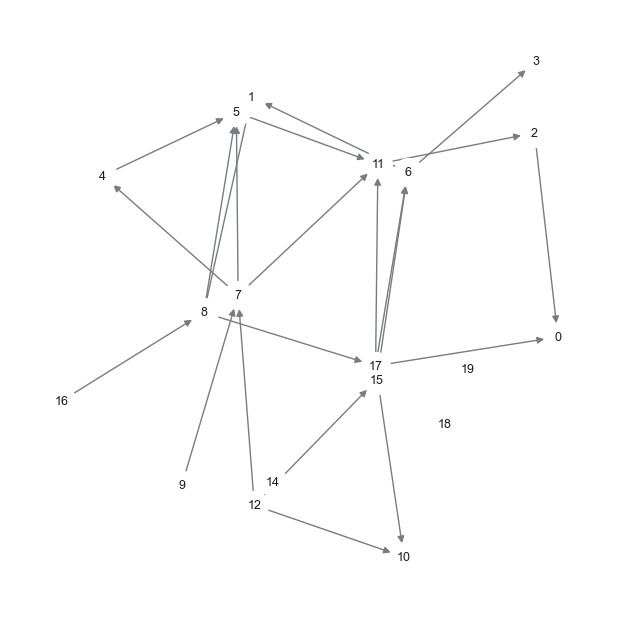

In [123]:
plt.figure(figsize=(6, 6))

# Example arrays of keys and values
keys = [i for i in range(len(data_keep.columns.drop('Fault')))]
values = data_keep.columns.drop('Fault')
# Initialize an empty dictionary
labels = {}
# Create the dictionary by iterating through the arrays
for i in range(len(keys)):
    labels[keys[i]] = values[i]
    


G = nx.DiGraph(DAG_estimate)
pos = nx.kamada_kawai_layout(G)  # Layout algorithm (you can choose other layouts)
nx.draw(G, pos, with_labels=True, labels=labels, node_size=400, node_color='white', edge_color='#767D80', font_size=9, arrows=True)
plt.show()